# Deep Learning Course Project
## Phase 2
### Saba Nasiri - 98101052
### Aliasghar Pourghani - 98101299
### Dariush Ghaemi - 98109678

# tf-idf vectors

In [96]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import random
from sklearn import svm
import re

In [97]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [98]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [99]:
def stop_word_remover(sent):
    filtered_sentence = []
    sent = sent.split(' ')
    for w in sent:
        if w not in stop_words:
            filtered_sentence.append(w)
    
    return ' '.join(filtered_sentence)

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_train = TfidfVectorizer()
vectorizer_test = TfidfVectorizer()


# Reading input data

english_train_add = "./MSCTD_dataset/english_train.txt"
english_test_add = "./MSCTD_dataset/english_test.txt"

sentiment_train_add = "./MSCTD_dataset/sentiment_train.txt"
sentiment_test_add = "./MSCTD_dataset/sentiment_test.txt"

corpus_text_train = []
corpus_text_test = []

corpus_sentiment_train = []
corpus_sentiment_test = []

#####################################################################################
txt_file = open(english_train_add, encoding="utf8")

for line in txt_file:
    
    a = re.sub(r'[^\w\s]','', stop_word_remover(line.strip())).lower()
    corpus_text_train.append(a)

train_tfidf = vectorizer_train.fit_transform(corpus_text_train)

txt_file.close()


#####################################################################################
txt_file = open(english_test_add, encoding="utf8")

for line in txt_file:
    
    a = stop_word_remover(re.sub(r'[^\w\s]','', line.strip()).lower())
    corpus_text_test.append(a)
    

test_tfidf = vectorizer_train.transform(corpus_text_test)

txt_file.close()



#####################################################################################
txt_file = open(sentiment_train_add, encoding="utf8")

for line in txt_file:
    corpus_sentiment_train.append(line.strip())

txt_file.close()

    
    
#####################################################################################
txt_file = open(sentiment_test_add, encoding="utf8")

for line in txt_file:
    corpus_sentiment_test.append(line.strip())
    
txt_file.close()

    


In [101]:
train_dictionary = vectorizer_train.get_feature_names_out()


In [102]:
test_tfidf_np = test_tfidf.toarray()
train_tfidf_np = train_tfidf.toarray()

In [103]:
class EmbeddingSet_tfidf(Dataset):    
    def __init__(self, line_vector, sentiment, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.sentiment = torch.tensor(sentiment)
        self.line_vector = line_vector
        
        
    def __len__(self):
        return len(self.sentiment)

    def __getitem__(self, idx):
        
        self.X = torch.tensor(self.line_vector[idx])
        self.y = self.sentiment[idx]
        return self.X, self.y


In [104]:
corpus_sentiment_train2 = [int(corpus_sentiment_train[i]) for i in range(len(corpus_sentiment_train))]
corpus_sentiment_test2 = [int(corpus_sentiment_test[i]) for i in range(len(corpus_sentiment_test))]
transform = transforms.ToTensor()
target_transform = transforms.ToTensor()
train_dataset1 = EmbeddingSet_tfidf(train_tfidf_np, corpus_sentiment_train2, transform, target_transform)
test_dataset1 = EmbeddingSet_tfidf(test_tfidf_np, corpus_sentiment_test2, transform, target_transform)


In [105]:
batch_size = 32
train_loader = DataLoader(train_dataset1,batch_size = batch_size,shuffle = True)
batch_size2=1
test_loader = DataLoader(test_dataset1,batch_size = batch_size2,shuffle = False)
print(len(test_loader))
print(len(train_loader))

5067
633


In [106]:
# Defining network
class MLP(nn.Module):
    def __init__(self, inputsize):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(inputsize, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 3)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.fc1(input)
        x = self.relu(x)
        x = self.fc2(x) 
        x = self.relu(x)
        x = self.fc3(x) 
        x = self.relu(x)
        x = self.fc4(x) 
        x = self.relu(x)
        x = self.fc5(x) 
        return x
    


In [107]:
MLPnetwork = MLP(len(train_tfidf_np[0])).to(device)

In [108]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(MLPnetwork.parameters(), lr=1e-4)

In [109]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        
        X = X.to(device)
        y = y.to(device)
        pred = model(X.float())

        loss = loss_fn(pred,y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
       
    
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>11f}  [{current:>5d}/{size:>5d}]")
    

In [110]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X=X.to(device)
            y = y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred,y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size

    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [111]:
for i in range(2):
    print('======================================================')
    print('epoch '+str(i))
    
    train_loop(train_loader, MLPnetwork, criterion, optimizer)
    test_loop(test_loader, MLPnetwork, criterion)
    

epoch 0
loss:    1.132343  [    0/20240]
loss:    1.090298  [ 3200/20240]
loss:    1.068661  [ 6400/20240]
loss:    1.081574  [ 9600/20240]
loss:    0.996265  [12800/20240]
loss:    1.021556  [16000/20240]
loss:    1.159712  [19200/20240]
Test: 
 Accuracy: 48.9%, Avg loss: 1.029445 

epoch 1
loss:    0.934937  [    0/20240]
loss:    0.811899  [ 3200/20240]
loss:    0.963568  [ 6400/20240]
loss:    1.006706  [ 9600/20240]
loss:    0.872145  [12800/20240]
loss:    0.889208  [16000/20240]
loss:    0.802548  [19200/20240]
Test: 
 Accuracy: 49.0%, Avg loss: 1.049467 



In [112]:
torch.save(MLPnetwork,"tfidfModel.pth")

TF-IDF stands for term frequency-inverse document frequency and it is a measure, used in the fields of information retrieval (IR) and machine learning, that can quantify the importance or relevance of string representations (words, phrases, lemmas, etc)  in a document amongst a collection of documents (also known as a corpus).

TF-IDF can be broken down into two parts TF (term frequency) and IDF (inverse document frequency).

TF : 

Term frequency works by looking at the frequency of a particular term you are concerned with relative to the document. 

IDF : 
Inverse document frequency looks at how common (or uncommon) a word is amongst the corpus.

In this part of the projact, tf-idf matrix of each corpus is used to embed sententences into vrctors. each row of the matrix is related to one line of the text. This row is used as the input of the network, and a mlp network is trained based on the labels of each sentence.

The final accuracy of this part is 50.5%.

# tf-idf and SVM

In [9]:
###############################

from tqdm import tqdm
words_tfidf_vectors = {}
g=-1
for line in tqdm(corpus_text_train):
    wordss = line.split(' ')
    words = [wordss[j] for j in range(len(wordss)) if len(wordss[j])>1]

    for i in range(len(words)):
        word = words[i]
        positive_label_words = words
        k = len(positive_label_words)
        
        negative_label_words = random.choices(train_dictionary, k = k)
        
        X = []
        
        y_pos = [1]*k
        y_neg = [0]*k
        y = y_pos + y_neg
        for w in positive_label_words + negative_label_words:
            X.append(train_tfidf[:,np.where(train_dictionary == w)[0][0]].toarray().reshape(20240))
        clf = svm.SVC()
        clf.fit(X, y)
        vectors = clf.support_vectors_[i]
        vectors = np.float32(vectors)
        if words_tfidf_vectors.get(word) is not None:
            words_tfidf_vectors[word].append(vectors)
        else:
            words_tfidf_vectors[word]=[]
            words_tfidf_vectors[word].append(vectors)
    

100%|████████████████████████████████████████████████████████████████████████████| 20240/20240 [37:17<00:00,  9.05it/s]


In [121]:
embeding_dictionary = {}

for word in train_dictionary:
    embeding_dictionary[word] = sum(words_tfidf_vectors[word])/len(words_tfidf_vectors[word])

In [123]:
class EmbeddingSet(Dataset):    
    def __init__(self, embedded_dictionary, text, sentiment, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.sentiment = torch.tensor(sentiment)
        self.text = text
        self.embedded_dictionary = embedded_dictionary
        
        
    def __len__(self):
        return len(self.sentiment)

    def __getitem__(self, idx):
        
        self.X = torch.tensor([])
        wordss = self.text[idx].split(' ')
        words = [wordss[j] for j in range(len(wordss)) if len(wordss[j])>1]
        word = [words[j] for j in range(len(words)) if words[j] in train_dictionary]
        n = len(word)
        for w in word:
            self.X = torch.cat((self.X, self.transform(self.embedded_dictionary[w].reshape(1,-1))), 0)

        self.X = self.X.squeeze(1).sum(0)/n
        
        self.y = self.sentiment[idx]

        return self.X, self.y


In [124]:
transform = transforms.ToTensor()
target_transform = transforms.ToTensor()
corpus_sentiment_train = [int(x) for x in corpus_sentiment_train]
corpus_text_train2 = []
corpus_sentiment_train2 = []
for i in range(len(corpus_text_train)):
    wordss = corpus_text_train[i].split(' ')
    words = [wordss[j] for j in range(len(wordss)) if len(wordss[j])>1]
    word = [words[j] for j in range(len(words)) if words[j] in train_dictionary]
    n = len(word)
    if n >0:
        corpus_text_train2.append(corpus_text_train[i])
        corpus_sentiment_train2.append(corpus_sentiment_train[i])
        
corpus_sentiment_test = [int(x) for x in corpus_sentiment_test]       
corpus_text_test2 = []
corpus_sentiment_test2 = []
for i in range(len(corpus_text_test)):
    wordss = corpus_text_test[i].split(' ')
    words = [wordss[j] for j in range(len(wordss)) if len(wordss[j])>1]
    word = [words[j] for j in range(len(words)) if words[j] in train_dictionary]
    n = len(word)
    if n >0:
        corpus_text_test2.append(corpus_text_test[i])
        corpus_sentiment_test2.append(corpus_sentiment_test[i])
        
train_dataset2 = EmbeddingSet(embeding_dictionary, corpus_text_train2, corpus_sentiment_train2, transform, target_transform)
test_dataset2 = EmbeddingSet(embeding_dictionary, corpus_text_test2, corpus_sentiment_test2, transform, target_transform)


In [15]:
batch_size = 1
train_loader2 = DataLoader(train_dataset2,batch_size = batch_size,shuffle = True)
batch_size2 = 1
test_loader2 = DataLoader(test_dataset2,batch_size = batch_size2,shuffle = False)
print(len(test_loader2))
print(len(train_loader2))

4869
20231


In [16]:
class SVMMLP(nn.Module):
    def __init__(self, inputsize):
        super(SVMMLP, self).__init__()
        self.fc1 = nn.Linear(inputsize, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 3)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.fc1(input)
        x = self.relu(x)
        x = self.fc2(x) 
        x = self.relu(x)
        x = self.fc3(x) 
        x = self.relu(x)
        x = self.fc4(x) 
        x = self.relu(x)
        x = self.fc5(x)
        
        return x
    

In [17]:
svmnetwork2 = SVMMLP(len(train_dataset2[0][0])).to(device)

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(svmnetwork2.parameters(), lr=1e-4)

In [19]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        
        X = X.to(device)
        y = y.to(device)
        pred = model(X.float())

        loss = loss_fn(pred,y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>11f}  [{current:>5d}/{size:>5d}]")
    

In [20]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X=X.to(device)
            y = y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred,y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size

    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [21]:
for i in range(10):
    print('======================================================')
    print('epoch '+str(i))
    
    train_loop(train_loader2, svmnetwork2, criterion, optimizer)
    test_loop(test_loader2, svmnetwork2, criterion)
    

epoch 0
loss:    0.935015  [    0/20231]
loss:    1.191685  [  100/20231]
loss:    1.187618  [  200/20231]
loss:    0.930415  [  300/20231]
loss:    0.924624  [  400/20231]
loss:    0.927944  [  500/20231]
loss:    1.250665  [  600/20231]
loss:    0.909742  [  700/20231]
loss:    0.931657  [  800/20231]
loss:    1.121886  [  900/20231]
loss:    1.289078  [ 1000/20231]
loss:    1.002137  [ 1100/20231]
loss:    1.282259  [ 1200/20231]
loss:    1.146538  [ 1300/20231]
loss:    1.094813  [ 1400/20231]
loss:    1.258454  [ 1500/20231]
loss:    1.164100  [ 1600/20231]
loss:    1.265068  [ 1700/20231]
loss:    1.141715  [ 1800/20231]
loss:    0.934202  [ 1900/20231]
loss:    1.252279  [ 2000/20231]
loss:    1.256956  [ 2100/20231]
loss:    1.259976  [ 2200/20231]
loss:    1.300965  [ 2300/20231]
loss:    1.314000  [ 2400/20231]
loss:    1.094827  [ 2500/20231]
loss:    1.333444  [ 2600/20231]
loss:    0.932487  [ 2700/20231]
loss:    1.255218  [ 2800/20231]
loss:    1.092344  [ 2900/20231]
lo

KeyboardInterrupt: 

In [23]:
torch.save(svmnetwork2, "SVMmodel.pth")

# GloVe

In [24]:
txt_file = open('glove.6B.50d.txt', encoding="utf8")
embeding_dictionary = {}
for line in txt_file:
    words = line.strip().split(' ')
    w = [float(x) for x in [*words[1:]]]
    embeding_dictionary[words[0]] = w

txt_file.close()


In [26]:
def zero_padding(vectors, leng, shape):
    for i in range(leng-len(vectors)):
        
        vectors = torch.cat((vectors, torch.zeros(1,shape)))
    return vectors

In [27]:
maxl = 24
class GloVeEmbeddingSet(Dataset):    
    def __init__(self, glove_dictionary, text, sentiment, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.sentiment = torch.tensor(sentiment)
        self.text = text
        self.glove_dictionary = glove_dictionary
        
    def __len__(self):
        return len(self.sentiment)

    def __getitem__(self, idx):
        self.X = torch.tensor([])      

        
        temp = []
        for w in self.text[idx].split(' '):
            if w in self.glove_dictionary:
                self.X = torch.cat((self.X, torch.tensor(self.glove_dictionary[w]).reshape(1,-1)), 0)
        
        
        self.X = zero_padding(self.X, maxl, 50)
        #print(self.X.shape)
        
        self.y = self.sentiment[idx]
        #self.X =  temp
        
        
        return self.X, self.y


In [29]:
transform = transforms.ToTensor()
target_transform = transforms.ToTensor()
corpus_sentiment_train = [int(x) for x in corpus_sentiment_train]

glove_train_dataset = GloVeEmbeddingSet(embeding_dictionary, corpus_text_train, corpus_sentiment_train, transform,
                                        target_transform)

corpus_sentiment_test = [int(x) for x in corpus_sentiment_test]
glove_test_dataset = GloVeEmbeddingSet(embeding_dictionary, corpus_text_test, corpus_sentiment_test, transform, target_transform)


In [32]:
batch_size = 1
glove_train_loader = DataLoader(glove_train_dataset,batch_size = batch_size,shuffle = True)
glove_test_loader = DataLoader(glove_test_dataset,batch_size = batch_size,shuffle = False)
print(len(glove_test_loader))
print(len(glove_train_loader))

5067
20240


In [33]:
class LSTMClassifier(nn.Module):
    def __init__(self, n_features, hidden_size):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_size, 3)

    def forward(self, X_batch):
        hidden, carry = torch.randn(1, len(X_batch), hidden_size).to(device), torch.randn(1, len(X_batch), hidden_size).to(device)
        output, (hidden, carry) = self.lstm(X_batch, (hidden, carry))
        return self.linear(output[:,-1])

In [34]:
hidden_size = 50
n_features = 50
network_glove = LSTMClassifier(n_features, hidden_size).to(device)

In [36]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network_glove.parameters(), lr=1e-4)

In [37]:
for i in range(20):
    print('======================================================')
    print('epoch '+str(i))
    
    train_loop(glove_train_loader, network_glove, criterion, optimizer)
    test_loop(glove_test_loader, network_glove, criterion)
    

epoch 0
loss:    1.069263  [    0/20240]
loss:    1.078519  [  100/20240]
loss:    1.011724  [  200/20240]
loss:    1.184547  [  300/20240]
loss:    1.165164  [  400/20240]
loss:    1.023875  [  500/20240]
loss:    1.113568  [  600/20240]
loss:    1.095052  [  700/20240]
loss:    1.096788  [  800/20240]
loss:    1.213474  [  900/20240]
loss:    1.008193  [ 1000/20240]
loss:    1.021959  [ 1100/20240]
loss:    1.225369  [ 1200/20240]
loss:    1.065101  [ 1300/20240]
loss:    1.064667  [ 1400/20240]
loss:    1.014936  [ 1500/20240]
loss:    1.015061  [ 1600/20240]
loss:    1.270620  [ 1700/20240]
loss:    1.025389  [ 1800/20240]
loss:    1.019625  [ 1900/20240]
loss:    1.284326  [ 2000/20240]
loss:    0.986905  [ 2100/20240]
loss:    1.044201  [ 2200/20240]
loss:    1.033126  [ 2300/20240]
loss:    1.047377  [ 2400/20240]
loss:    1.299248  [ 2500/20240]
loss:    1.039205  [ 2600/20240]
loss:    0.999944  [ 2700/20240]
loss:    1.043051  [ 2800/20240]
loss:    0.980233  [ 2900/20240]
lo

KeyboardInterrupt: 

In [38]:
torch.save(network_glove,"GloveModel.pth")

# Bert and classification

In [9]:
maxl=18

In [60]:


english_train_add = "./MSCTD_dataset/english_train.txt"
english_test_add = "./MSCTD_dataset/english_test.txt"

sentiment_train_add = "./MSCTD_dataset/sentiment_train.txt"
sentiment_test_add = "./MSCTD_dataset/sentiment_test.txt"

corpus_text_train = []
corpus_text_test = []

corpus_sentiment_train = []
corpus_sentiment_test = []

#####################################################################################
txt_file = open(english_train_add, encoding="utf8")

for line in txt_file:
    a = line.strip()
    corpus_text_train.append(re.sub(r'[^\w\s]','', a).lower())

txt_file.close()


#####################################################################################
txt_file = open(english_test_add, encoding="utf8")

for line in txt_file:
    a = line.strip()
    corpus_text_test.append(re.sub(r'[^\w\s]','', a).lower())

txt_file.close()



#####################################################################################
txt_file = open(sentiment_train_add, encoding="utf8")

for line in txt_file:
    corpus_sentiment_train.append(line.strip())

txt_file.close()
    
#####################################################################################
txt_file = open(sentiment_test_add, encoding="utf8")

for line in txt_file:
    corpus_sentiment_test.append(line.strip())
    
txt_file.close()

    


In [61]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [63]:
from transformers import BertModel

class BertDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.labels = [dataset[i][1] for i in range(len(dataset))]
        self.texts = [ tokenizer(dataset[i][0], padding='max_length', max_length = maxl, truncation=True, return_tensors="pt")['input_ids'] for i in range(len(dataset))]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        batch_texts = self.texts[idx]
        batch_y = torch.tensor(int(self.labels[idx]))
        return batch_texts, batch_y

In [64]:
from transformers import BertModel
class BertClassifier(nn.Module):

    def __init__(self):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc1 = nn.Linear(768, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 3)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        
        out = self.bert(inputs)
        output = self.fc1(out[1])
        output = self.relu(output)
        output = self.fc2(output)
        output = self.relu(output)
        output = self.fc3(output)

        return output

In [65]:
bertclassifier = BertClassifier().to(device)
bertclassifier.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [66]:
trainset = [[corpus_text_train[x], corpus_sentiment_train[x]] for x in range(len(corpus_sentiment_train))]
testset = [[corpus_text_test[x], corpus_sentiment_test[x]] for x in range(len(corpus_sentiment_test))]


In [67]:
learning_rate = 1e-5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(bertclassifier.parameters(), lr=learning_rate, eps=1e-8) 

In [68]:
 train, test = BertDataset(trainset), BertDataset(testset)

In [69]:
bert_trainloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
bert_testloader = torch.utils.data.DataLoader(test, batch_size=64)

In [71]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct=0
    for batch, (X, y) in enumerate(dataloader):
        X=X.squeeze(1).to(device)
        y=y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X=X.squeeze(1).to(device)
            y=y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [72]:
epochs=5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(bert_trainloader, bertclassifier, loss_fn, optimizer)
    test_loop(bert_testloader, bertclassifier, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.094602  [    0/20240]
loss: 1.064679  [ 6400/20240]
loss: 0.941850  [12800/20240]
loss: 0.919585  [19200/20240]
Test Error: 
 Accuracy: 59.6%, Avg loss: 0.932393 

Epoch 2
-------------------------------
loss: 0.861210  [    0/20240]
loss: 0.847534  [ 6400/20240]
loss: 0.898930  [12800/20240]
loss: 0.802000  [19200/20240]
Test Error: 
 Accuracy: 61.4%, Avg loss: 0.877759 

Epoch 3
-------------------------------
loss: 0.660818  [    0/20240]


KeyboardInterrupt: 

In [ ]:
torch.save(bertclassifier,"bertclassifier.pth")

# Evaluation and Results

In [113]:
tfidfmodel = torch.load("tfidfModel.pth")

In [74]:
svmmodel = torch.load("SVMmodel.pth")

In [75]:
glovemodel = torch.load("GloveModel.pth")

In [76]:
bertmodel = torch.load("bertclassifier.pth")

### accuracy

from the previous parts, the accuracies are as follows :

part 1, model based on tf-idf  : 49%

part 2, model based on svm : 48%

part 3, model based on GloVe : 48.7%

part 4, model based on Bert : 61.4%



### f1 score

In [118]:
def evaluation(dataset, model):
    predicted=[]
    real=[]
    with torch.no_grad():
        for i in range(len(dataset)):
            X=dataset[i][0]
            y=dataset[i][1].item()
            pred = model(X.float()).argmax()
            predicted.append(pred)
            real.append(y)
    return predicted, real

In [119]:
ptfidf, rtfidf = evaluation(test_dataset1, tfidfmodel.to("cpu"))

In [125]:
psvm, rsvm = evaluation(test_dataset2, svmmodel.to("cpu"))

In [142]:
def glovevaluation(dataset, model):
    predicted=[]
    real=[]
    with torch.no_grad():
        for i in range(len(dataset)):
            X=dataset[i][0].reshape(1,24,50).to(device)
            y=dataset[i][1].item()
            pred = model(X.float()).argmax()
            predicted.append(pred)
            real.append(y)
    return predicted, real

In [143]:
pglove, rglove = glovevaluation(glove_test_dataset, glovemodel.to("cuda:0"))

In [146]:
def bertevaluation(dataset, model):
    predicted=[]
    real=[]
    with torch.no_grad():
        for i in range(len(dataset)):
            X=dataset[i][0]
            y=dataset[i][1].item()
            pred = model(X).argmax(1)[0].item()
            predicted.append(pred)
            real.append(y)
    return predicted, real

In [147]:
pbert, rbert = bertevaluation(test, bertmodel.to("cpu"))

#### part 1, model based on tf-idf

In [148]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(rtfidf, ptfidf))

              precision    recall  f1-score   support

           0       0.33      0.48      0.39      1298
           1       0.58      0.61      0.60      2163
           2       0.59      0.34      0.43      1606

    accuracy                           0.49      5067
   macro avg       0.50      0.48      0.47      5067
weighted avg       0.52      0.49      0.49      5067



#### part 2, model based on svm

In [149]:
print(classification_report(rsvm, psvm))

              precision    recall  f1-score   support

           0       0.36      0.52      0.42      1224
           1       0.63      0.40      0.49      2076
           2       0.47      0.53      0.50      1569

    accuracy                           0.47      4869
   macro avg       0.49      0.48      0.47      4869
weighted avg       0.51      0.47      0.48      4869



#### part 3, model based on GloVe 

In [154]:
print(classification_report(torch.tensor(rglove).to("cpu"), torch.tensor(pglove).to("cpu")))

              precision    recall  f1-score   support

           0       0.35      0.65      0.46      1298
           1       0.57      0.55      0.56      2163
           2       0.61      0.24      0.35      1606

    accuracy                           0.48      5067
   macro avg       0.51      0.48      0.46      5067
weighted avg       0.53      0.48      0.47      5067



#### part 4, model based on Bert

In [155]:
print(classification_report(rbert, pbert))

              precision    recall  f1-score   support

           0       0.44      0.62      0.52      1298
           1       0.70      0.66      0.68      2163
           2       0.66      0.50      0.57      1606

    accuracy                           0.60      5067
   macro avg       0.60      0.59      0.59      5067
weighted avg       0.62      0.60      0.60      5067



### confusion matrix

#### part 1, model based on tf-idf

In [157]:
from sklearn.metrics import confusion_matrix

cf_mat1=confusion_matrix(rtfidf, ptfidf, labels=[0, 1, 2])
cf_mat1

array([[ 628,  484,  186],
       [ 653, 1314,  196],
       [ 612,  451,  543]], dtype=int64)

<AxesSubplot:>

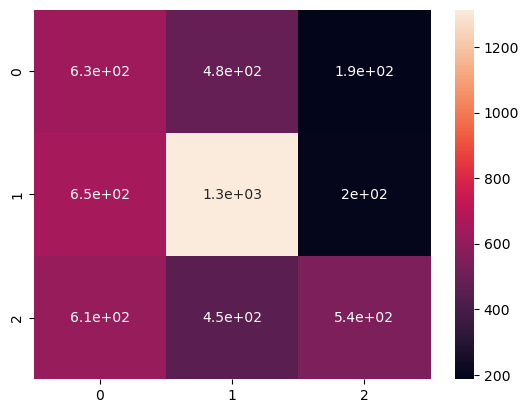

In [158]:
import seaborn as sns
sns.heatmap(cf_mat1, annot=True)

#### part 2, model based on svm

In [159]:
cf_mat2=confusion_matrix(rsvm, psvm, labels=[0, 1, 2])
cf_mat2

array([[639, 227, 358],
       [667, 837, 572],
       [487, 258, 824]], dtype=int64)

<AxesSubplot:>

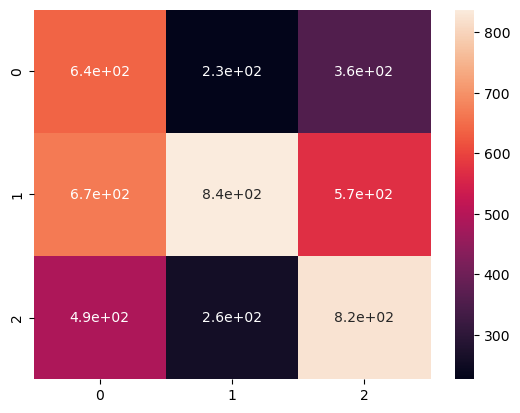

In [160]:
sns.heatmap(cf_mat2, annot=True)

#### part 3, model based on GloVe 

In [162]:
cf_mat3=confusion_matrix(torch.tensor(rglove).to("cpu"), torch.tensor(pglove).to("cpu"), labels=[0, 1, 2])
cf_mat3

array([[ 838,  385,   75],
       [ 811, 1181,  171],
       [ 714,  500,  392]], dtype=int64)

<AxesSubplot:>

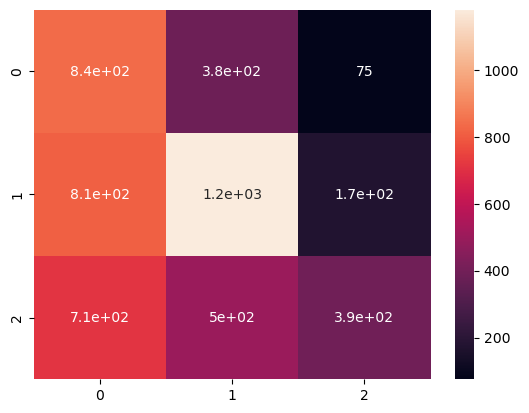

In [163]:
sns.heatmap(cf_mat3, annot=True)

#### part 4, model based on Bert

In [164]:
cf_mat4=confusion_matrix(rbert, pbert, labels=[0, 1, 2])
cf_mat4

array([[ 809,  287,  202],
       [ 525, 1419,  219],
       [ 489,  310,  807]], dtype=int64)

<AxesSubplot:>

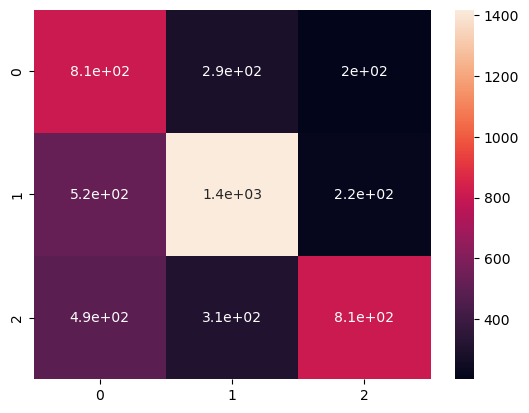

In [165]:
sns.heatmap(cf_mat4, annot=True)